In [12]:
import sys
import pandas as pd
import nflreadpy as nfl

sys.path.append('../py')
from preprocess import preprocess
from nflplotlib import nflplot as nfp

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
sup_data = pd.read_csv('../data/supplementary_data.csv')
tracking_input = pd.read_csv('../data/train/input_2023_w01.csv')
tracking_output = pd.read_csv('../data/train/output_2023_w01.csv')

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_36535/766476731.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  sup_data = pd.read_csv('../data/supplementary_data.csv')


In [14]:
games, plays, players, tracking = preprocess.process_data(tracking_input, tracking_output, sup_data)
team_desc = preprocess.fetch_team_desc()

2025-12-13 13:11:58,188 - INFO - Joined input and output tracking data: 819 unique plays, 737 unique nfl_ids
2025-12-13 13:11:58,189 - INFO - Standardizing direction of play and players to be left to right
2025-12-13 13:11:58,251 - INFO - Approximating missing speed, acceleration and direction values
2025-12-13 13:11:58,391 - INFO - Correlation results for imputations: s_approx: speed R²=0.9864 | a_approx: accel R²=0.0340 | dir_approx: dir R²=0.0469
2025-12-13 13:11:58,419 - INFO - Joining supplemental data to plays DataFrame
2025-12-13 13:11:58,435 - INFO - Loading NFL PBP data for season 2023
2025-12-13 13:11:58,436 - INFO - Loading pbp from local parquet file
2025-12-13 13:11:58,567 - INFO - Mapping player IDs to nfl_id using seasonal rosters
2025-12-13 13:11:58,567 - INFO - Rosters for season 2023 already cached, loading from parquet
2025-12-13 13:12:08,125 - WARNING - Dropping gpid 2023091001_3216 with no passer and no QB
2025-12-13 13:12:08,172 - WARNING - Dropping gpid 202309100

In [15]:
results = (
    pd.read_csv('../data/results/epa_preds.csv')
    .merge(
        plays[['gpid', 'absolute_yardline_number', 'ball_land_x', 'ball_land_y','num_frames_output']],
        on='gpid', how='left')
    .assign(
        x=lambda x: x['absolute_yardline_number'] + x['x'],
        start_x=lambda x: x['absolute_yardline_number'] + x['start_x'],
    )
)
results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_epa,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,-1.988009,42,63.259998,-0.22,21
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,2.988215,42,63.259998,-0.22,21
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,3.008903,42,63.259998,-0.22,21
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,3.028923,42,63.259998,-0.22,21
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,3.045521,42,63.259998,-0.22,21


In [16]:
gpids = results.gpid.unique()

len(gpids)

213

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from models.safety_reachable_points import safety_reach
# x:51.28, y:16.959999999999994, dir:306.33, speed:4.21
x = 51.28
y = 16.959999999999994
dir = 306.33
speed = 4.21
vx = speed * np.cos(np.deg2rad(dir))
vy = speed * np.sin(np.deg2rad(dir))

inial_pos =np.array([x, y])
inial_vel = np.array([vx, vy])

outer_reach = safety_reach.simulate_outer_points(inial_pos, inial_vel)

def plot_safety_reach_heatmap(df):
    """
    df must contain:
    - x, y, vx, vy for simulated/original points
    - start_x, start_y, start_dir, start_s for the safety origin
    - predicted_epa
    """

    safety_nlf_id = df["safety_nfl_id"].iloc[0]
    df = df.query('safety_nfl_id == @safety_nlf_id')

    # Extract safety start information (same for all rows in group)
    start_x = df["start_x"].iloc[0]
    start_y = df["start_y"].iloc[0]

    # Convert the direction + speed into a vector for plotting
    # start_dir is in degrees, convert to radians
    dir_rad = np.deg2rad(df["start_dir"].iloc[0])
    speed = df["start_s"].iloc[0]

    vec_dx = np.cos(dir_rad) * speed
    vec_dy = np.sin(dir_rad) * speed

    # Extract simulated points (exclude original if you want)
    sim = df[df["sample_type"] == "simulated"]

    xs = sim["x"].values
    ys = sim["y"].values
    epa = sim["predicted_epa"].values

    # Create figure
    plt.figure(figsize=(10, 6))

    # Create a grid for interpolation
    grid_resolution = 200
    xi = np.linspace(xs.min(), xs.max(), grid_resolution)
    yi = np.linspace(ys.min(), ys.max(), grid_resolution)
    xi_grid, yi_grid = np.meshgrid(xi, yi)

    # Interpolate EPA values onto the grid using cubic interpolation
    zi_grid = griddata((xs, ys), epa, (xi_grid, yi_grid), method='cubic', fill_value=np.nan)

    # Create a mask for points outside the convex hull (to maintain the circular shape)
    from scipy.spatial import ConvexHull
    points = np.column_stack((xs, ys))
    hull = ConvexHull(points)
    
    # Create path from hull vertices to mask outside points
    from matplotlib.path import Path
    hull_path = Path(points[hull.vertices])
    grid_points = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    mask = hull_path.contains_points(grid_points).reshape(xi_grid.shape)
    zi_grid[~mask] = np.nan

    # Plot the gradient heatmap
    im = plt.contourf(xi_grid, yi_grid, zi_grid, levels=40, cmap="RdYlGn_r", alpha=0.8, zorder=3)
    
    # Add contour lines for better visualization
    plt.contour(xi_grid, yi_grid, zi_grid, levels=10, alpha=0.3, linewidths=0.5, zorder=4)

    # --- Safety starting point & vector ---
    plt.scatter(start_x, start_y, color="grey", s=50, label="Safety start", 
                zorder=6, edgecolors='black', linewidths=2)
    plt.arrow(start_x, start_y, vec_dx, vec_dy,
              head_width=0.5, head_length=0.8,
              fc="black", ec="black", linewidth=1, zorder=5)
    
    # plot actual end point (sample_type == 'original')
    original = df[df["sample_type"] == "original"].iloc[0]
    plt.scatter(original["x"], original["y"], color="black", s=50, label="Actual end point", 
                zorder=6, edgecolors='black', linewidths=2)
    # print(f"Actual end point: ({original['x']}, {original['y']})")
    
    # plot absolute yardline line
    yardline = df["absolute_yardline_number"].iloc[0]
    plt.axvline(x=yardline, color='purple', linestyle='--', label='Absolute Yardline', zorder=2)

    # Plot ball landing point as an x
    ball_x = df["ball_land_x"].iloc[0]
    ball_y = df["ball_land_y"].iloc[0]
    plt.scatter(ball_x, ball_y, marker='x', color='red', s=100, label='Ball Landing Point', zorder=7)

    # plot offense and defense on last frame of play besides safety_nfl_id in diff color
    gpid = df["gpid"].iloc[0]
    last_frame = tracking.query('gpid == @gpid').frame_id.max()
    last_frame_data = tracking.query('gpid == @gpid & frame_id == @last_frame')
    defenders = last_frame_data.query('player_side == "Defense" & nfl_id != @safety_nlf_id')
    offenses = last_frame_data.query('player_side == "Offense"')
    plt.scatter(defenders.x, defenders.y, color='orange', s=50, label='Defenders', zorder=6, edgecolors='black', linewidths=1)
    plt.scatter(offenses.x, offenses.y, color='cyan', s=50, label='Offense', zorder=9, edgecolors='black', linewidths=1)
    # plot offense arrows
    for _, row in offenses.iterrows():
        dir_rad = np.deg2rad(row['dir'])
        vec_dx = np.cos(dir_rad) * row['s'] * 0.5
        vec_dy = np.sin(dir_rad) * row['s'] * 0.5
        plt.arrow(row['x'], row['y'], vec_dx, vec_dy,
                  head_width=0.3, head_length=0.5,
                  fc="black", ec="black", linewidth=1, zorder=7)
    # plot defense arrows
    for _, row in defenders.iterrows():
        dir_rad = np.deg2rad(row['dir'])
        vec_dx = np.cos(dir_rad) * row['s'] * 0.5
        vec_dy = np.sin(dir_rad) * row['s'] * 0.5
        plt.arrow(row['x'], row['y'], vec_dx, vec_dy,
                  head_width=0.3, head_length=0.5,
                  fc="black", ec="black", linewidth=1, zorder=7)

    # safety_end = last_frame_data.query('nfl_id == @safety_nlf_id')
    # plt.scatter(safety_end.x, safety_end.y, color='green', s=100, label='Safety Actual End', zorder=8, edgecolors='black', linewidths=2)
    # print(f"Safety actual end: ({safety_end.x.values[0]}, {safety_end.y.values[0]})")

    # plot ball start point
    ball_start_frame = tracking.query('gpid == @gpid & ~pass_thrown').frame_id.max()
    ball_start = tracking.query('gpid == @gpid & frame_id == @ball_start_frame & player_side == "Ball"')
    plt.scatter(ball_start.x, ball_start.y, marker='x', color='brown', s=100, label='Ball Start', zorder=7)

    # plot line between ball start and ball landing
    plt.plot([ball_start.x.values[0], ball_x], [ball_start.y.values[0], ball_y], color='brown', linestyle='--', label='Ball Path', zorder=2)

    # move legend outside of plot
    plt.legend(bbox_to_anchor=(-.5, 1), loc='upper left')

    # if x max is above 120, set xlim to 120
    plt.axis('equal')
    print(xs.max())
    if xs.max() > 120:
        plt.xlim(ball_start.x.values[0] - 3, 120)

    # Colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("Predicted EPA")
    print(gpid)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

46.72332444529259
2023091007_3542


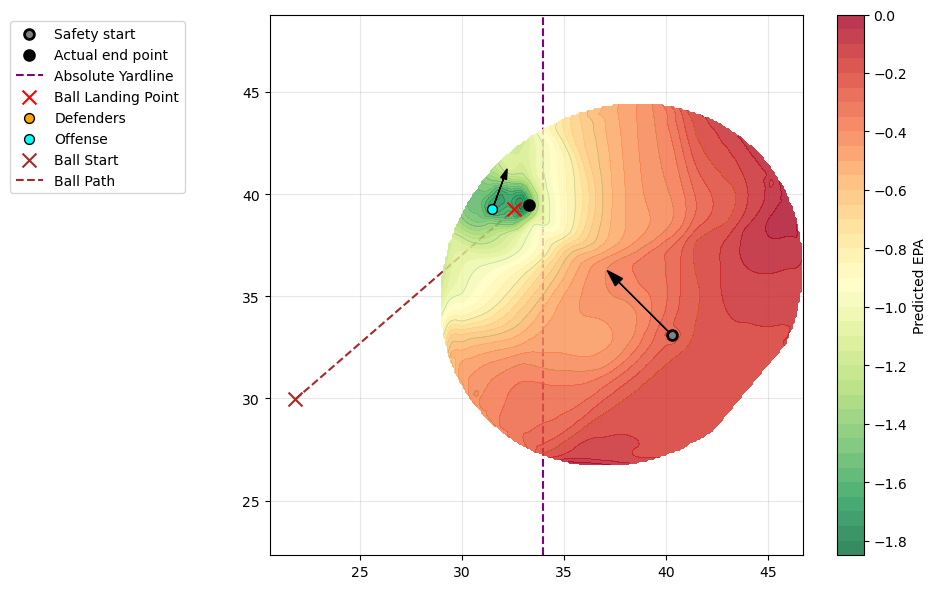

In [18]:
gpid = results["gpid"].unique()[110]
example_df = results[results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df)

119.16240099289976
2023091007_935


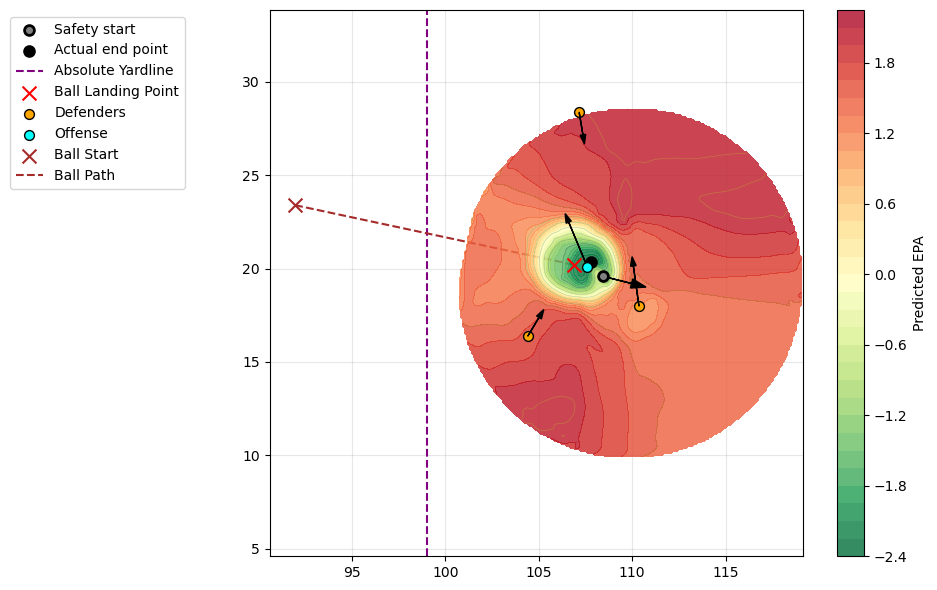

In [19]:
gpid = results["gpid"].unique()[112]
example_df = results[results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df)

2025-12-13 13:12:10,521 - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


124.07688684342898
2023091008_1200


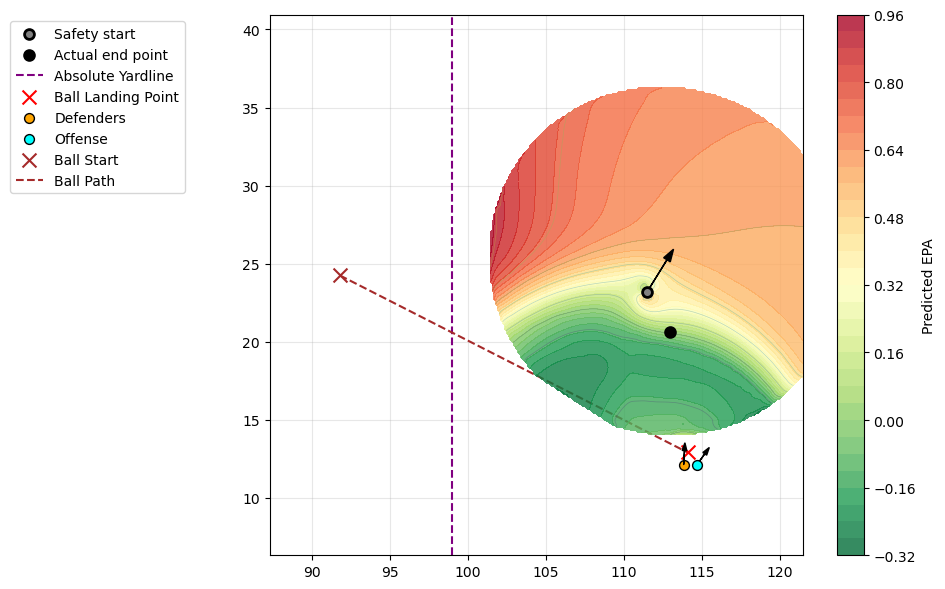

In [20]:
gpid = results["gpid"].unique()[114]
example_df = results[results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df)

In [21]:
plays.query('gpid=="2023091008_1200"').play_description.values[0]

'(9:08) (Shotgun) J.Fields pass incomplete short right to C.Kmet (R.Douglas).'

In [22]:
plays.query('gpid=="2023091008_1200"').to_dict(orient="records")

[{'gpid': '2023091008_1200',
  'game_id': 2023091008,
  'play_id': 1200,
  'absolute_yardline_number': 99,
  'num_frames_output': 11,
  'ball_land_x': 114.069999694824,
  'ball_land_y': 12.8999996185303,
  'season': 2023,
  'week': 1,
  'play_description': '(9:08) (Shotgun) J.Fields pass incomplete short right to C.Kmet (R.Douglas).',
  'quarter': 2,
  'game_clock': '09:08',
  'down': 3,
  'yards_to_go': 11,
  'possession_team': 'CHI',
  'defensive_team': 'GB',
  'yardline_side': 'GB',
  'yardline_number': 11,
  'pre_snap_home_score': 3,
  'pre_snap_visitor_score': 7,
  'play_nullified_by_penalty': 'N',
  'pass_result': 'I',
  'pass_length': 11,
  'offense_formation': 'SHOTGUN',
  'receiver_alignment': '3x1',
  'route_of_targeted_receiver': 'HITCH',
  'play_action': False,
  'dropback_type': 'TRADITIONAL',
  'dropback_distance': 2.60999989509583,
  'pass_location_type': 'INSIDE_BOX',
  'defenders_in_the_box': 5,
  'team_coverage_man_zone': 'ZONE_COVERAGE',
  'team_coverage_type': 'COVE